In [69]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

In [70]:
import time
import matplotlib.pyplot as plt
import numpy as np
import keras
from skimage.filters import gabor_kernel
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from keras import backend as K
if K.backend()=='tensorflow':
    K.image_data_format()
from skimage.color import rgb2gray
from scipy import ndimage as ndi
 
# Import Tensorflow with multiprocessing
import tensorflow as tf
import multiprocessing as mp
 
# Loading the CIFAR-10 datasets
from keras.datasets import cifar10
import cv2
import pickle

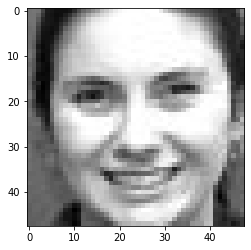

In [71]:
DATADIR = "/content/Datasets"
CATEGORIES = ["Happy","Angry"]

for category in CATEGORIES:
  path = os.path.join(DATADIR,category)
  for img in os.listdir(path):
    img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
    plt.imshow(img_array,cmap="gray")
    plt.show()
    break
  break

In [72]:
print(img_array.shape)

(48, 48)


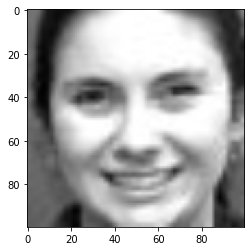

In [73]:
IMG_SIZE=100

new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
plt.imshow(new_array,cmap="gray")
plt.show()

In [74]:
training_data = []

def create_training_data():

  for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    class_num = CATEGORIES.index(category)
    for img in os.listdir(path):
      try:
        img_array = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE)
        new_array = cv2.resize(img_array,(IMG_SIZE,IMG_SIZE))
        training_data.append([new_array,class_num])
      except Exception as e:
        pass
create_training_data()

In [75]:
print(len(training_data))

221


In [76]:
import random
random.shuffle(training_data)

In [77]:
X = []
Y= []

In [78]:
for features , label in training_data:
  X.append(features)
  Y.append(label)

X = np.array(X).reshape(-1,IMG_SIZE,IMG_SIZE,1)

In [79]:
Y = np.array(Y)

In [80]:
#X = np.array(X,dtype='float64')
#Y = np.array(Y, dtype ='float64')

In [81]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,Y)

In [14]:
#y_train = np.asarray(y_train).astype('float32').reshape((-1,1))
#y_test = np.asarray(y_test).astype('float32').reshape((-1,1))

Simple CNN model

In [15]:
def base_model():
    model = Sequential()
    model.add(Conv2D(48, (3, 3), padding='same', data_format='channels_last', input_shape=(100,100,1)))
    model.add(Activation('relu'))
    model.add(Conv2D(48, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
    # Train model
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [16]:
model = base_model()
model.summary()
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), shuffle=True)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 48)      480       
_________________________________________________________________
activation (Activation)      (None, 100, 100, 48)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 98, 48)        20784     
_________________________________________________________________
activation_1 (Activation)    (None, 98, 98, 48)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 49, 49, 48)        0         
_________________________________________________________________
dropout (Dropout)            (None, 49, 49, 48)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 49, 49, 64)        2

In [17]:
print(X_test.shape)

(56, 100, 100, 1)


In [18]:
print(y_test.shape)

(56,)


Gabor with CNN model  

In [82]:
def custom_gabor(shape, dtype=None):
    pi = np.pi
    orientation_spread = np.array([0, pi/4, pi/2, pi*3/4, pi, pi*5/4, pi*3/2, 2*pi])
    scales = np.linspace(2, 3, 5)
    real_kernels = []
    img_kernels = []
#     size, sigma, theta, lambda, gamma aspect ratio
    for orientation in orientation_spread:
        for scale in scales:
            real_kernel = cv2.getGaborKernel((5, 5), 1, orientation, scale, 1, 0)
            imaginary_kernel = cv2.getGaborKernel((5, 5), 1, orientation, scale, 1, np.pi / 2)
            real_kernels.append(real_kernel)
            img_kernels.append(imaginary_kernel)
    stacked_list = np.vstack((real_kernels, img_kernels))
    # stack number equal to number of color channel RGB: ([stacked_list, stacked_list, stacked_list])
    stacked_list = np.array([stacked_list])
    stacked_list = np.einsum('hijk->jkhi', stacked_list)
    print(stacked_list.shape)

    stacked_list = K.variable(stacked_list)
    random = K.random_normal(shape, dtype=dtype)
    return stacked_list


In [83]:
def base_model():
    model = Sequential()
    model.add(Conv2D(80, (5, 5), padding='same',kernel_initializer=custom_gabor, data_format='channels_last', input_shape=(100,100,1)))
    model.add(Activation('relu'))
    model.add(Conv2D(48, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    opt = keras.optimizers.RMSprop(lr=0.0001, decay=1e-6)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model


In [84]:
model = base_model()
model.layers[0].trainable = False
model.summary()
history = model.fit(X_train, y_train, batch_size=16, epochs=30, validation_data=(X_test, y_test), shuffle=True)

(5, 5, 1, 80)
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 100, 100, 80)      2080      
_________________________________________________________________
activation_36 (Activation)   (None, 100, 100, 80)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 98, 98, 48)        34608     
_________________________________________________________________
activation_37 (Activation)   (None, 98, 98, 48)        0         
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 49, 49, 48)        0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 49, 49, 48)        0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 49, 

On training model with 50 epoch we get an training accuracy of around 99% while validation accuracy of around 94%.

Here we have used two classes i.e happy and angry.

In [168]:
from PIL import Image, ImageFont, ImageDraw 


In [238]:
a = '/content/1_Final1.jpg'

In [239]:
img_array1 = cv2.imread(a,cv2.IMREAD_GRAYSCALE)
new_array1 = cv2.resize(img_array1,(IMG_SIZE,IMG_SIZE))

In [240]:
p = np.array(new_array1).reshape(-1,IMG_SIZE,IMG_SIZE,1)

In [241]:
n=model.predict(p)

In [242]:

n=np.round(n)
c = n[0][0]


1.0


In [243]:
my_image = Image.open(a)


In [244]:
font = ImageFont.load_default()


In [245]:
if c<=0:
  title_text="Happy"
else:
  title_text="Angry"


In [246]:
image_editable = ImageDraw.Draw(my_image)
image_editable.text((15,15), title_text, (237, 230, 211), font=font)


In [247]:
my_image.save("Predicted_Result1.jpg")
